In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from mlxtend.classifier import StackingClassifier
from subprocess import check_output
train_df = pd.read_csv('survey.csv')
print(train_df.shape)

(1259, 27)


In [15]:
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(10)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
5,33,Male,United States,NaN,Yes,No,Sometimes,6-25,No,Yes,...,Don't know,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No
6,35,Female,United States,NaN,Yes,Yes,Sometimes,1-5,Yes,Yes,...,No,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No
7,39,M,Canada,NaN,No,No,Never,1-5,Yes,Yes,...,Yes,Don't know,No,No,No,No,No,No,No,No
8,42,Female,United States,NaN,Yes,Yes,Sometimes,100-500,No,Yes,...,No,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No
9,23,Male,Canada,NaN,No,No,Never,26-100,No,Yes,...,Don't know,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No


In [21]:
gender = train_df['Gender'].str.lower()
gender = train_df['Gender'].unique()
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)
        
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [22]:
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

In [23]:
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [24]:
train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [25]:
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue  
for key, value in labelDict.items():     
    print(key, value)
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


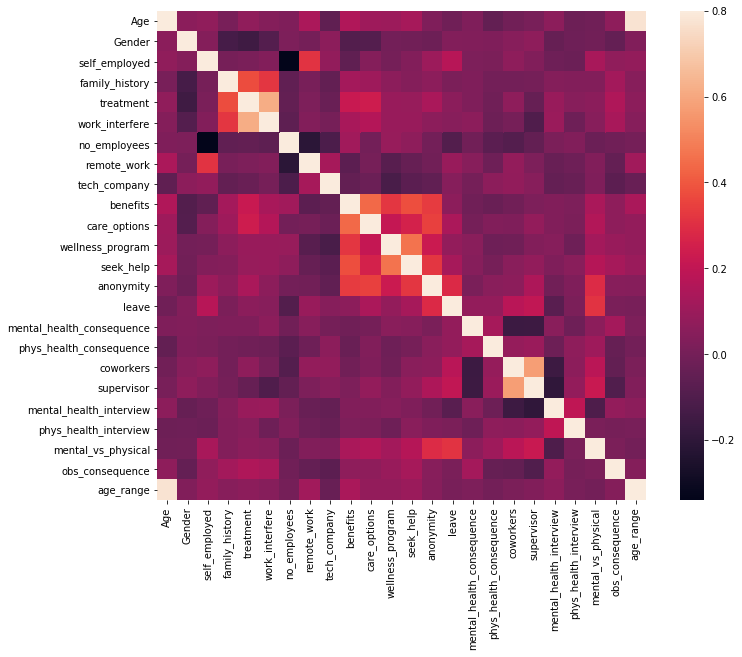

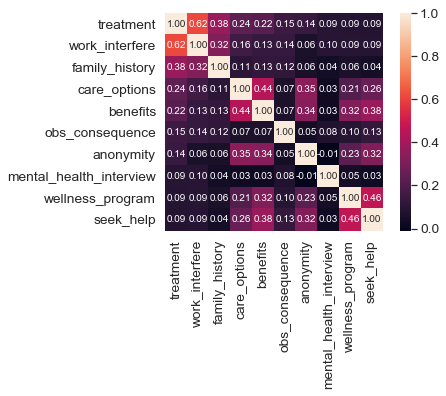

In [26]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()
k = 10
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Text(0.5,0,'Age')

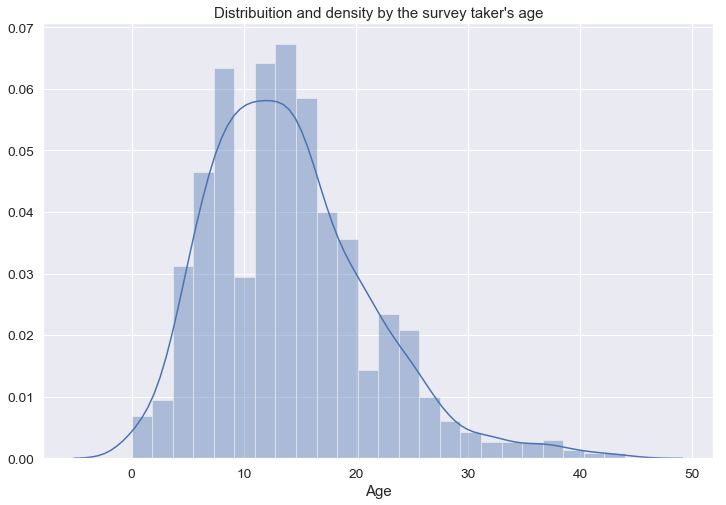

In [28]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Distribuition and density by the survey taker's age")
plt.xlabel("Age")

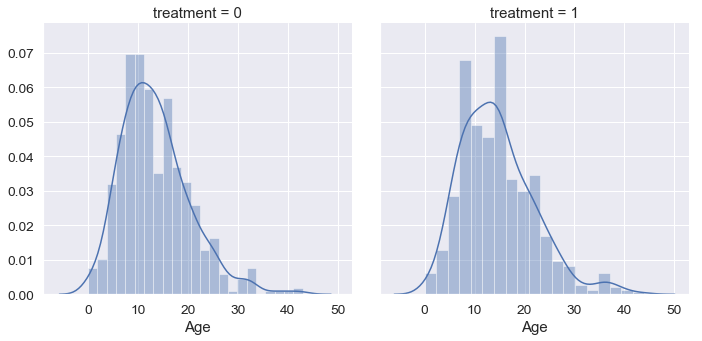

In [30]:
g = sns.FacetGrid(train_df, col='treatment', height=5)
g = g.map(sns.distplot, "Age")

Text(0.5,1,'Total Distribuition by treated or not')

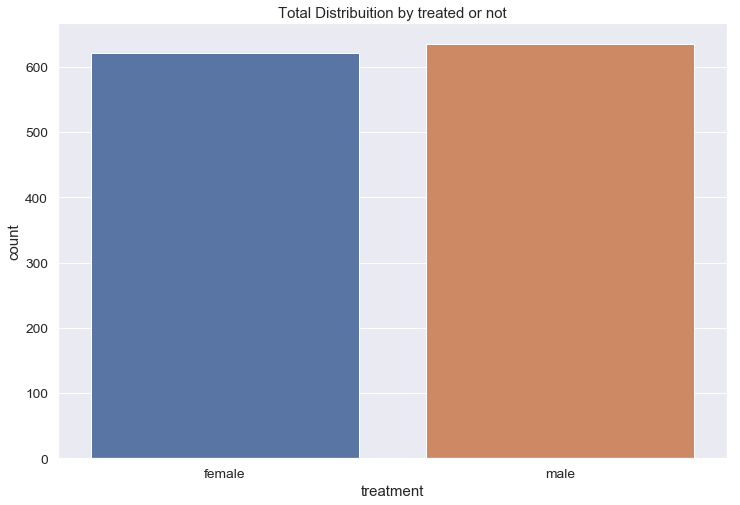

In [31]:
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

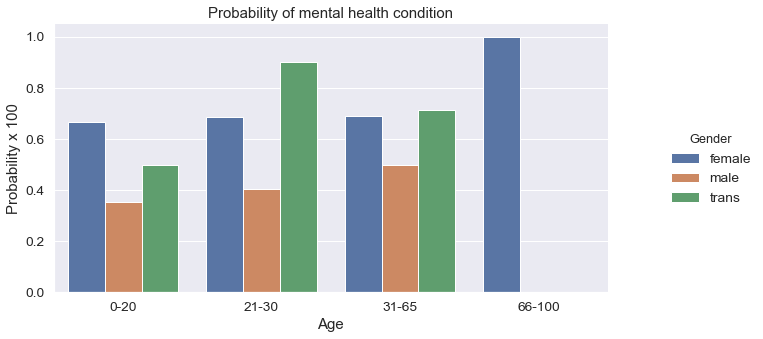

In [34]:
o = labelDict['label_age_range']

g = sns.catplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

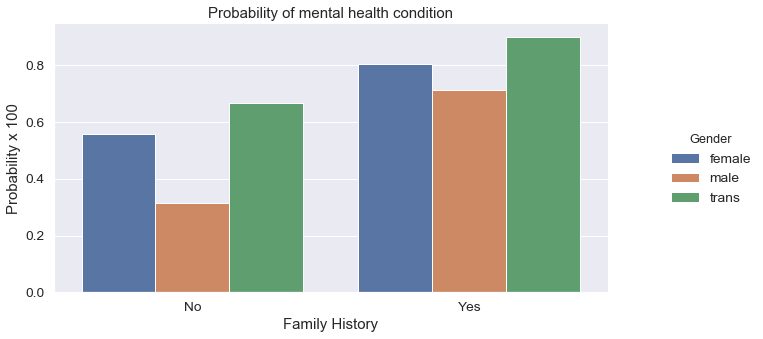

In [37]:
o = labelDict['label_family_history']
g = sns.catplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

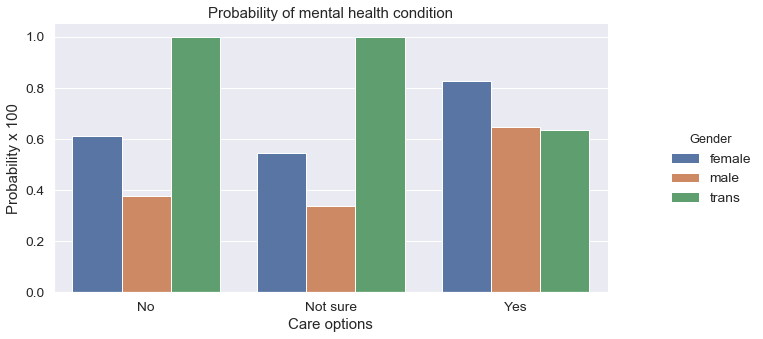

In [38]:
o = labelDict['label_care_options']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

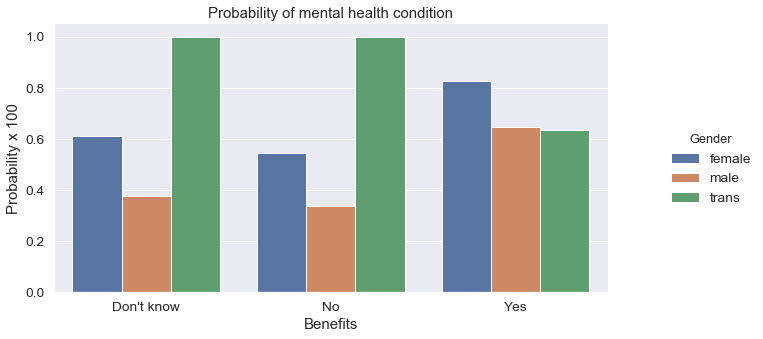

In [40]:
o = labelDict['label_benefits']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

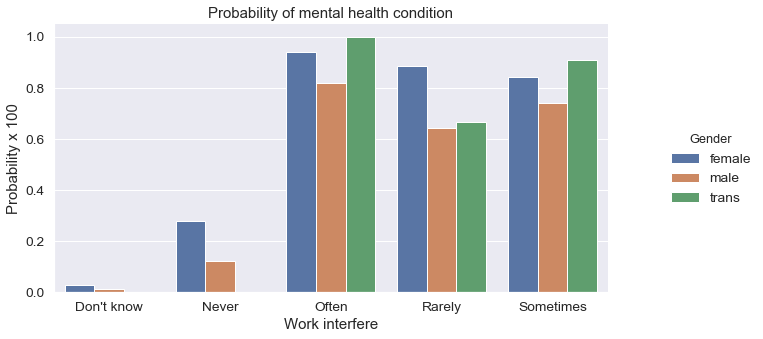

In [42]:
o = labelDict['label_work_interfere']
g = sns.catplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

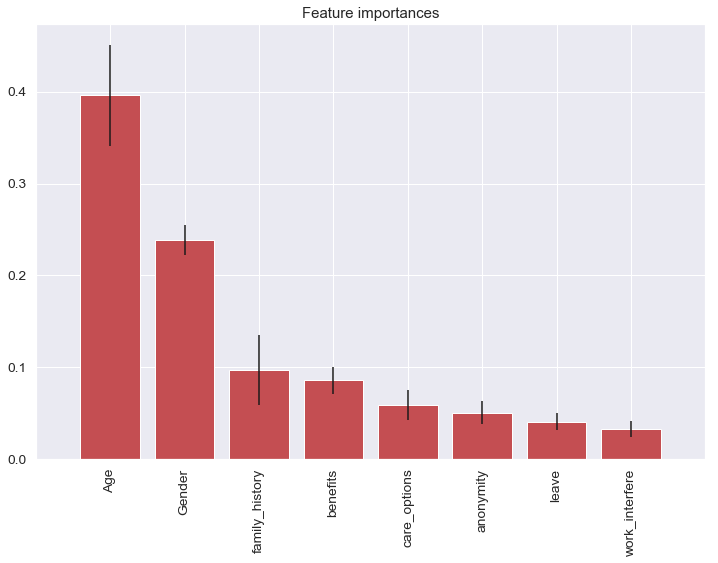

In [43]:
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])

feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
methodDict = {}
rmseDict = ()
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

def evalClassModel(model, y_test, y_pred_class, plot=False):
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    print('Null accuracy:\n', y_test.value_counts())
    print('Percentage of ones:', y_test.mean())
    print('Percentage of zeros:',1 - y_test.mean())
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])
    model.predict_proba(X_test)[0:10, 1]
    f
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=8)
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()      
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    def evaluate_threshold(threshold):
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    return accuracy        


In [71]:
def tuningCV(knn):
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
def tuningGridSerach(knn):
    k_range = list(range(1, 31))
    print(k_range)
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y)
    grid.grid_scores_
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    print('GridSearch best score', grid.best_score_)
    print('GridSearch best params', grid.best_params_)
    print('GridSearch best estimator', grid.best_estimator_)
    
def tuningRandomizedSearchCV(model, param_dist):
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.grid_scores_
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)
    
def tuningMultParam(knn):
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid) 
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y) 
    print(grid.grid_scores_)
    print('Multiparam. Best Score: ', grid.best_score_)
    print('Multiparam. Best Params: ', grid.best_params_)

Here is logistic regression!
Accuracy: 0.798941798941799
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


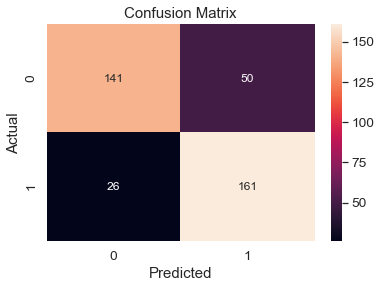

Classification Accuracy: 0.798941798941799
Classification Error: 0.20105820105820105
False Positive Rate: 0.2617801047120419
Precision: 0.7630331753554502
AUC Score: 0.799591231066439
Cross-validated AUC: 0.875357422875064
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.09763161 0.90236839]
 [0.95330977 0.04669023]
 [0.96013985 0.03986015]
 [0.78441354 0.21558646]
 [0.37834349 0.62165651]
 [0.06235819 0.93764181]
 [0.74803691 0.25196309]
 [0.1743978  0.8256022 ]
 [0.61145489 0.38854511]
 [0.49232517 0.50767483]]
First 10 predicted probabilities:
 [[0.90236839]
 [0.04669023]
 [0.03986015]
 [0.21558646]
 [0.62165651]
 [0.93764181]
 [0.25196309]
 [0.8256022 ]
 [0.38854511]
 [0.50767483]]


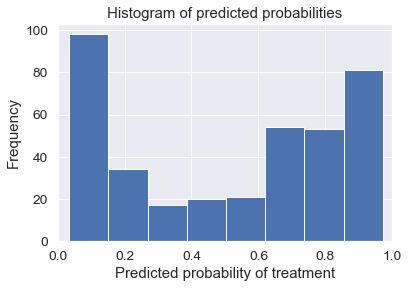

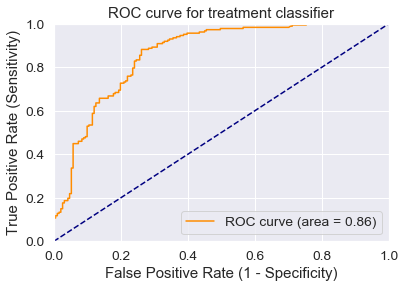

[[141  50]
 [ 26 161]]


In [83]:
def logisticRegression():
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred_class = logreg.predict(X_test)
    
    print('Here is logistic regression!')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    methodDict['Log. Regres.'] = accuracy_score * 100
    
logisticRegression()

Rand. Best Score:  0.8194112967382657
Rand. Best Params:  {'weights': 'uniform', 'n_neighbors': 15}
[0.815, 0.819, 0.819, 0.814, 0.814, 0.82, 0.819, 0.818, 0.814, 0.819, 0.815, 0.815, 0.819, 0.82, 0.814, 0.815, 0.819, 0.819, 0.819, 0.815]
Here is some K Neighbours Classifier!
Accuracy: 0.8042328042328042
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


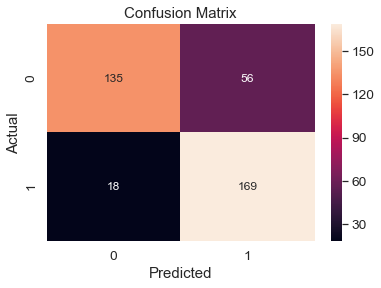

Classification Accuracy: 0.8042328042328042
Classification Error: 0.1957671957671958
False Positive Rate: 0.2931937172774869
Precision: 0.7511111111111111
AUC Score: 0.8052747991152673
Cross-validated AUC: 0.8788016433051714
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.33333333 0.66666667]
 [1.         0.        ]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.37037037 0.62962963]
 [0.03703704 0.96296296]
 [0.59259259 0.40740741]
 [0.37037037 0.62962963]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]]
First 10 predicted probabilities:
 [[0.66666667]
 [0.        ]
 [0.        ]
 [0.33333333]
 [0.62962963]
 [0.96296296]
 [0.40740741]
 [0.62962963]
 [0.66666667]
 [0.66666667]]


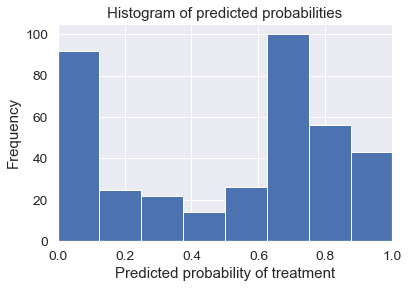

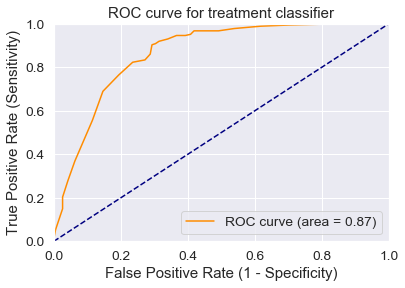

[[135  56]
 [ 18 169]]


In [84]:
def Knn():
    knn = KNeighborsClassifier(n_neighbors=5)
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist)
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    
    print('Here is some K Neighbours Classifier!')
    
    accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)
    methodDict['KNN'] = accuracy_score * 100

Knn()

Rand. Best Score:  0.8305489260143198
Rand. Best Params:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}
[0.831, 0.829, 0.831, 0.831, 0.83, 0.831, 0.829, 0.831, 0.823, 0.83, 0.827, 0.831, 0.829, 0.829, 0.831, 0.801, 0.826, 0.829, 0.829, 0.804]
Here is a tree classifier!
Accuracy: 0.8068783068783069
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


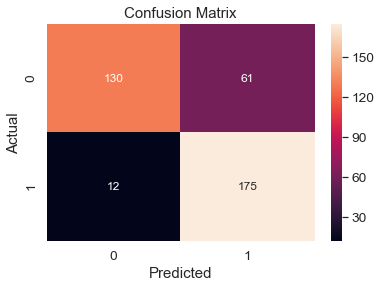

Classification Accuracy: 0.8068783068783069
Classification Error: 0.19312169312169314
False Positive Rate: 0.3193717277486911
Precision: 0.7415254237288136
AUC Score: 0.8082285746283282
Cross-validated AUC: 0.8729276673707117
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.18823529 0.81176471]
 [0.95575221 0.04424779]
 [0.95575221 0.04424779]
 [0.95575221 0.04424779]
 [0.37583893 0.62416107]
 [0.05172414 0.94827586]
 [0.90384615 0.09615385]
 [0.37583893 0.62416107]
 [0.22018349 0.77981651]
 [0.22018349 0.77981651]]
First 10 predicted probabilities:
 [[0.81176471]
 [0.04424779]
 [0.04424779]
 [0.04424779]
 [0.62416107]
 [0.94827586]
 [0.09615385]
 [0.62416107]
 [0.77981651]
 [0.77981651]]


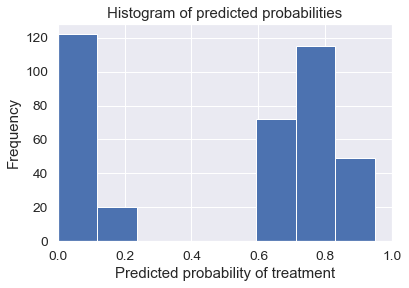

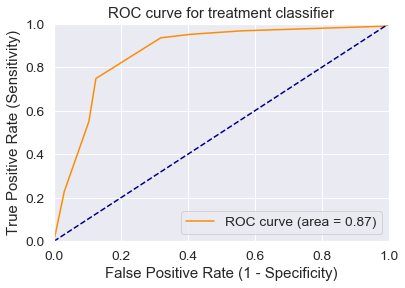

[[130  61]
 [ 12 175]]


In [74]:
def treeClassifier():
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)
    y_pred_class = tree.predict(X_test)
    print('Here is a tree classifier!')
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)
    methodDict['Tree clas.'] = accuracy_score * 100
    
treeClassifier()

In [85]:
import tensorflow as tf
import argparse


batch_size = 100
train_steps = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

def train_input_fn(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset


In [86]:
age = tf.feature_column.numeric_column("Age")
gender = tf.feature_column.numeric_column("Gender")
family_history = tf.feature_column.numeric_column("family_history")
benefits = tf.feature_column.numeric_column("benefits")
care_options = tf.feature_column.numeric_column("care_options")
anonymity = tf.feature_column.numeric_column("anonymity")
leave = tf.feature_column.numeric_column("leave")
work_interfere = tf.feature_column.numeric_column("work_interfere")
feature_columns = [age, gender, family_history, benefits, care_options, anonymity, leave, work_interfere]

model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                    hidden_units=[10, 10],
                                    optimizer=tf.train.ProximalAdagradOptimizer(
                                      learning_rate=0.1,
                                      l1_regularization_strength=0.001
                                    ))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HARSHI~1\\AppData\\Local\\Temp\\tmp24fzgndx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001CB00B89828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [87]:
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HARSHI~1\AppData\Local\Temp\tmp24fzgndx\model.ckpt.
INFO:tensorflow:loss = 184.73691, step = 1
INFO:tensorflow:global_step/sec: 497.952
INFO:tensorflow:loss = 42.41343, step = 101 (0.201 sec)
INFO:tensorflow:global_step/sec: 777.551
INFO:tensorflow:loss = 34.67246, step = 201 (0.129 sec)
INFO:tensorflow:global_step/sec: 747.363
INFO:tensorflow:loss = 36.38639, step = 301 (0.134 sec)
INFO:tensorflow:global_step/sec: 808.625
INFO:tensorflow:loss = 33.839825, step = 401 (0.124 sec)
INFO:tensorflow:global_step/sec: 778.086
INFO:tensorflow:loss = 45.781887, step = 501 (0.129 sec)
INFO:tensorflow:global_step/sec: 799.375
INFO:tensorflow:loss = 34.093143, step = 601 (0.125 sec)
INFO:tensorflow:global_step/

In [88]:
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))
print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))
accuracy = eval_result['accuracy'] * 100

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-25-17:49:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\HARSHI~1\AppData\Local\Temp\tmp24fzgndx\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-25-17:49:50
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7962963, accuracy_baseline = 0.505291, auc = 0.881485, auc_precision_recall = 0.86343837, average_loss = 0.44296432, global_step = 1000, label/mean = 0.49470899, loss = 41.860126, precision = 0.74122804, prediction/mean = 0.5145126, recall = 0.9037433
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\HARSHI~1\AppData\Local\Temp\tmp24fzgndx\model.ckpt-1000

Test set accuracy: 0.80



In [89]:
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\HARSHI~1\AppData\Local\Temp\tmp24fzgndx\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [90]:
template = ('\nIndex: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')
col1 = []
col2 = []
col3 = []
for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0] 
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id]
    col1.append(idx)
    col2.append(v) 
    col3.append(input) 
results = pd.DataFrame({'index':col1, 'prediction':col2, 'expected':col3})
results.head()

,index,prediction,expected
0,929,0,0
1,901,1,1
2,579,1,1
3,367,1,1
4,615,1,1


In [107]:
print("THE ACCURACIES ARE:")
print(methodDict['Logistic Regression'])
print(methodDict['K Neighbours Classifier'])
print(methodDict['Tree Classifier'])

THE ACCURACIES ARE:
79.8941798941799
80.42328042328042
80.68783068783068


In [108]:
clf = AdaBoostClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
results.to_csv('Eunoia_Results.csv', index=False)
results.head()

,Index,Treatment
0,5,1
1,494,0
2,52,0
3,984,0
4,186,0


In [109]:
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
results.to_csv('Eunoia_Results.csv', index=False)